In [1]:
# Task: Comparison of optimization methods for classification on Image dataset 1
# • Model: MLFFNN with 2 hidden layers and tanh activation function
# • Lossfunction: Cross-entropy
# • Mode of learning: Pattern mode
# • Stopping criterion: Change in average error below a threshold
# • Weight update rules: (1) Delta rule, (2) Generalized delta rule, (3) AdaGrad, 
# (4) RMSProp, (5) AdaM
# • Use the same value of learning rate parameter
# • Use the same initial random values of weights
# • For each rule of weight update,reportshould include the following: (a) Plot of average
# error on training data vs Epoch, (b) Confusion matricesfor training data and test data
# • Compare number of epochs taken for convergence for different update rules.

# You can use Pytorch as well. No need to implement neural network from scratch.
# You can use any library for plotting the graphs.

In [2]:
# Dataset:
# it is in ./task1 folder
# the folder has 6 files
# test_data.csv
# test_label.csv
# train_data.csv
# train_label.csv
# val_data.csv
# val_label.csv

# Train data shape -> (2000, 36)
# Train label shape -> (2000, 1)
# Test data shape -> (500, 36)
# Test label shape -> (500, 1)
# Val data shape -> (500, 36)
# Val label shape -> (500, 1)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Set seed for reproducibility
seed = 59+87+122+143
np.random.seed(seed)
torch.manual_seed(seed)


In [5]:
class DataLoader:
    def __init__(self, train_data_path, train_label_path, val_data_path, val_label_path, test_data_path, test_label_path):
        self.train_data, self.train_labels = self.load_data(train_data_path, train_label_path)
        self.val_data, self.val_labels = self.load_data(val_data_path, val_label_path)
        self.test_data, self.test_labels = self.load_data(test_data_path, test_label_path)

    def load_data(self, data_path, label_path):
        data = pd.read_csv(data_path, header=None).values.astype(np.float32)
        labels = pd.read_csv(label_path, header=None).values.flatten().astype(np.int64)
        return data, labels

    def normalize_data(self):
        scaler = StandardScaler()
        scaler.fit(self.train_data)
        self.train_data = scaler.transform(self.train_data)
        self.val_data = scaler.transform(self.val_data)
        self.test_data = scaler.transform(self.test_data)


In [6]:
class MLFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
class Trainer:
    def __init__(self, model, criterion, optimizer, epochs, threshold):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.threshold = threshold

    def train(self, train_data, train_labels):
        train_errors = []
        for epoch in range(self.epochs):
            running_loss = 0.0
            for i in range(len(train_data)):
                inputs = torch.tensor(train_data[i], dtype=torch.float32)
                labels = torch.tensor(train_labels[i], dtype=torch.long)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            train_errors.append(running_loss / len(train_data))

            if epoch > 0 and abs(train_errors[epoch] - train_errors[epoch - 1]) < self.threshold:
                print(f"Training stopped at epoch {epoch}")
                break

        return train_errors


In [8]:
class Evaluator:
    @staticmethod
    def evaluate(model, data, labels):
        predictions = []
        for i in range(len(data)):
            inputs = torch.tensor(data[i], dtype=torch.float32)
            outputs = model(inputs).argmax().item()
            predictions.append(outputs)

        return confusion_matrix(labels, predictions)


In [9]:
class Visualizer:
    @staticmethod
    def plot_errors(train_errors):
        plt.plot(range(len(train_errors)), train_errors)
        plt.xlabel("Epoch")
        plt.ylabel("Average Error")
        plt.title("Average Error on Training Data vs Epoch")
        plt.show()

    @staticmethod
    def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
        plt.title(title)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

In [ ]:
class DeltaRule(optim.Optimizer):
    def __init__(self, params, lr=0.01):
        defaults = dict(lr=lr)
        super(DeltaRule, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                p.data.sub_(group['lr'] * grad)

class GeneralizedDeltaRule(optim.Optimizer):
    def __init__(self, params, lr=0.01, prev_grads=None):
        defaults = dict(lr=lr, prev_grads=prev_grads)
        super(GeneralizedDeltaRule, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if group['prev_grads'] is None:
                    prev_grads = torch.zeros_like(grad)
                else:
                    prev_grads = group['prev_grads']
                p.data.sub_(group['lr'] * grad * torch.sign(grad - prev_grads))
                group['prev_grads'] = grad

class AdaGrad(optim.Optimizer):
    def __init__(self, params, lr=0.01, eps=1e-8):
        defaults = dict(lr=lr, eps=eps)
        super(AdaGrad, self).__init__(params, defaults)
        self.eps = eps

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                if 'sum' not in state:
                    state['sum'] = torch.zeros_like(p.data)
                state['sum'] += grad.pow(2)
                p.data.sub_(group['lr'] * grad / (torch.sqrt(state['sum']) + self.eps))

class RMSProp(optim.Optimizer):
    def __init__(self, params, lr=0.01, beta=0.9, eps=1e-8):
        defaults = dict(lr=lr, beta=beta, eps=eps)
        super(RMSProp, self).__init__(params, defaults)
        self.eps = eps

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                if 'square_avg' not in state:
                    state['square_avg'] = torch.zeros_like(p.data)
                state['square_avg'] = group['beta'] * state['square_avg'] + (1 - group['beta']) * grad.pow(2)
                p.data.sub_(group['lr'] * grad / (torch.sqrt(state['square_avg']) + self.eps))

class AdaM(optim.Optimizer):
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps)
        super(AdaM, self).__init__(params, defaults)
        self.eps = eps

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                if 'step' not in state:
                    state['step'] = 0
                if 'm' not in state:
                    state['m'] = torch.zeros_like(p.data)
                if 'v' not in state:
                    state['v'] = torch.zeros_like(p.data)
                state['step'] += 1
                state['m'] = group['beta1'] * state['m'] + (1 - group['beta1']) * grad
                state['v'] = group['beta2'] * state['v'] + (1 - group['beta2']) * grad.pow(2)
                m_hat = state['m'] / (1 - group['beta1'] ** state['step'])
                v_hat = state['v'] / (1 - group['beta2'] ** state['step'])
                p.data.sub_(group['lr'] * m_hat / (torch.sqrt(v_hat) + self.eps))


In [14]:
# Paths to data files
train_data_path = "./task1/train_data.csv"
train_label_path = "./task1/train_label.csv"
val_data_path = "./task1/val_data.csv"
val_label_path = "./task1/val_label.csv"
test_data_path = "./task1/test_data.csv"
test_label_path = "./task1/test_label.csv"

# Load and normalize data
data_loader = DataLoader(train_data_path, train_label_path, val_data_path, val_label_path, test_data_path, test_label_path)
# data_loader.normalize_data()

# Define model parameters
input_size = data_loader.train_data.shape[1]
hidden_size1 = 32
hidden_size2 = 16
output_size = len(np.unique(data_loader.train_labels))  # Number of unique classes
epochs = 1000
learning_rate = 0.01
threshold = 0.001


Training stopped at epoch 74
Confusion Matrix for Training Data:
[[  0   0   0   0 400]
 [  0   0   0   0 400]
 [  0   0   0   0 400]
 [  0   0   0   0 400]
 [  0   0   0   0 400]]
Confusion Matrix for Validation Data:
[[  0   0   0   0 100]
 [  0   0   0   0 100]
 [  0   0   0   0 100]
 [  0   0   0   0 100]
 [  0   0   0   0 100]]
Confusion Matrix for Test Data:
[[  0   0   0   0 100]
 [  0   0   0   0 100]
 [  0   0   0   0 100]
 [  0   0   0   0 100]
 [  0   0   0   0 100]]


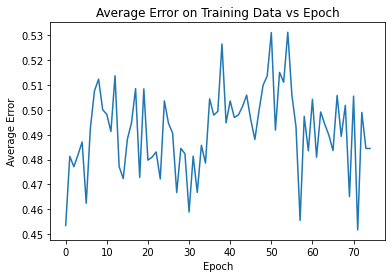

In [16]:
# Initialize the model
model = MLFFNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
trainer = Trainer(model, criterion, optimizer, epochs, threshold)
train_errors = trainer.train(data_loader.train_data, data_loader.train_labels)

# Evaluate the model
conf_matrix_train = Evaluator.evaluate(model, data_loader.train_data, data_loader.train_labels)
conf_matrix_val = Evaluator.evaluate(model, data_loader.val_data, data_loader.val_labels)
conf_matrix_test = Evaluator.evaluate(model, data_loader.test_data, data_loader.test_labels)

# Print the confusion matrices
print("Confusion Matrix for Training Data:")
print(conf_matrix_train)
# print("Confusion Matrix for Validation Data:")
# print(conf_matrix_val)
print("Confusion Matrix for Test Data:")
print(conf_matrix_test)

# Plot the average error on training data vs Epoch
Visualizer.plot_errors(train_errors)
